In [9]:
# Import dependencies
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image
import subprocess
# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import matplotlib.pyplot as plt

# Database Connection and Loading Data

In [10]:
# (Windows) Data was added to mongo Database MusicDB via cmd line before running this script 

In [11]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client['Music_db']
db.list_collection_names()


['fs.chunks', 'feat_3', 'feat_30', 'fs.files']

In [12]:
# Select 'features_3_sec' collection, and read in as pandas DataFrame
collection = db['feat_3'].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df
features_df = features_3_df
features_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
1,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
2,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [13]:
cwd_bytes = subprocess.check_output("pwd")
cwd = cwd_bytes.decode("utf-8").rstrip("\n") + "/"
cwd


'/Users/Miles/desktop/Berkeley_Camp/MusicClassification/'

In [14]:
# identify path for images
images_path = "Data/images_original/"

In [15]:
byte_images = subprocess.check_output(["ls", cwd + images_path])
images_folder = byte_images.decode("utf-8").split("\n")
images_folder.pop(-1)
images_folder

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [16]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

In [17]:
image_full_data = []
genres_full_data = []

for folder in images_folder:
    byte_files = subprocess.check_output(["ls", cwd + images_path + folder])
    files = byte_files.decode("utf-8").split("\n")
    files.pop(-1)
    
    for file in files:
        file_path = images_path + folder + "/" + file
        image_raw = fs.get_last_version(file_path)
        image_data = image_raw.read()
        image = Image.open(io.BytesIO(image_data))
        image_data = np.asarray(image)
        image_full_data.append(image_data)
        genres_full_data.append(folder)

# Build, Train, and Test Models to Predict `label` from feature data

## `DecisionTreeClassifier`

In [18]:
# Separate Features (X) from the Target (y)
y = features_df["label"]
X = features_df.drop(columns="label", axis=1)

In [19]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
1,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
2,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [20]:
# Encode class labels in target y
genre_nums = {}
cnt = 1
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 1,
 'classical': 2,
 'country': 3,
 'disco': 4,
 'hiphop': 5,
 'jazz': 6,
 'metal': 7,
 'pop': 8,
 'reggae': 9,
 'rock': 10}

In [21]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
# Instantitae DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

# Fit the model
tree_model = tree_model.fit(X_train, y_train)

# Make predictions using the testing data
tree_pred = tree_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": tree_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,9
1,9,9
2,7,10
3,1,1
4,7,10
...,...,...
2493,2,2
2494,5,4
2495,3,3
2496,1,1


In [24]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, tree_pred)
cm

array([[148,   2,  13,  15,   3,  15,  15,   4,   9,  12],
       [  1, 213,   3,   1,   0,  19,   1,   1,   1,   7],
       [ 34,   7, 135,  19,   4,  25,   5,  14,   7,  13],
       [  7,   2,  10, 127,  20,   6,  10,  15,  17,  15],
       [  8,   0,   4,  18, 176,   2,   9,  22,  17,   6],
       [ 12,  24,  18,   9,   4, 163,   4,   1,   4,  12],
       [  9,   0,   5,   8,  12,   4, 193,   1,   1,  26],
       [  1,   1,  12,  13,   9,   6,   0, 175,  14,  11],
       [  9,   1,  10,  15,  25,   6,   1,   9, 178,  11],
       [ 18,   8,  26,  20,  11,  17,  23,   7,  12, 102]])

In [25]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, tree_pred)
acc_score

0.644515612489992

In [26]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           1       0.60      0.63      0.61       236
           2       0.83      0.86      0.84       247
           3       0.57      0.51      0.54       263
           4       0.52      0.55      0.54       229
           5       0.67      0.67      0.67       262
           6       0.62      0.65      0.63       251
           7       0.74      0.75      0.74       259
           8       0.70      0.72      0.71       242
           9       0.68      0.67      0.68       265
          10       0.47      0.42      0.44       244

    accuracy                           0.64      2498
   macro avg       0.64      0.64      0.64      2498
weighted avg       0.64      0.64      0.64      2498



## `KNN`

In [27]:
# Instantiate SVM
knn_model = KNeighborsClassifier(n_neighbors=21)

# Fit the model
knn_model = knn_model.fit(X_train, y_train)

# Make predicitions using the testing data
knn_pred = knn_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": knn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,10,9
1,2,9
2,4,10
3,7,1
4,7,10
...,...,...
2493,2,2
2494,3,4
2495,4,3
2496,10,1


In [28]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, knn_pred)
cm

array([[ 34,  13,  23,  27,  19,  41,  39,  10,  12,  18],
       [ 12, 167,   7,   1,   0,  16,  38,   0,   4,   2],
       [ 21,  18,  50,  44,  13,  26,  27,  16,  26,  22],
       [ 27,   2,  19,  52,  32,   4,  17,  22,  27,  27],
       [ 12,   2,  16,  44,  38,   1,  22,  59,  53,  15],
       [ 34,  23,  33,  22,   6,  55,  33,  14,  11,  20],
       [ 26,  32,  21,  24,  10,  12, 107,   0,   4,  23],
       [  6,   3,  10,  30,  37,  13,   6,  91,  40,   6],
       [ 11,   3,  28,  34,  22,   7,  16,  45,  88,  11],
       [ 20,  12,  36,  46,  23,  21,  36,  15,  18,  17]])

In [29]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, knn_pred)
acc_score

0.2798238590872698

In [30]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           1       0.17      0.14      0.15       236
           2       0.61      0.68      0.64       247
           3       0.21      0.19      0.20       263
           4       0.16      0.23      0.19       229
           5       0.19      0.15      0.16       262
           6       0.28      0.22      0.25       251
           7       0.31      0.41      0.36       259
           8       0.33      0.38      0.35       242
           9       0.31      0.33      0.32       265
          10       0.11      0.07      0.08       244

    accuracy                           0.28      2498
   macro avg       0.27      0.28      0.27      2498
weighted avg       0.27      0.28      0.27      2498



## Naive-Bayes Classifier

In [31]:
# Instantiate the model
gnb_model = GaussianNB()

# Fit the model
gnb_model = gnb_model.fit(X_train, y_train)

# Make predicitions using the testing data
gnb_pred = gnb_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": gnb_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,4,9
1,8,9
2,5,10
3,7,1
4,7,10
...,...,...
2493,6,2
2494,4,4
2495,10,3
2496,7,1


In [32]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, gnb_pred)
cm

array([[ 55,  17,  32,   5,   1,  28,  77,   0,  15,   6],
       [  2, 219,   2,   0,   0,   9,  10,   1,   2,   2],
       [ 16,  16,  85,  38,   4,   9,  57,   1,  21,  16],
       [  8,   2,   7,  92,  10,   2,  76,   5,  16,  11],
       [  8,   0,  25,  47,  62,   1,  50,  21,  43,   5],
       [ 22,  50,  13,  27,   0,  57,  48,   5,   6,  23],
       [  1,   1,   1,  10,   7,   0, 232,   1,   2,   4],
       [  1,   2,   6,  57,  10,   3,  19, 116,  23,   5],
       [ 26,   1,  31,  30,  22,   1,   7,  19, 120,   8],
       [  3,  12,  25,  36,  11,   2, 109,   4,  18,  24]])

In [33]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, gnb_pred)
acc_score

0.42514011208967173

In [34]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           1       0.39      0.23      0.29       236
           2       0.68      0.89      0.77       247
           3       0.37      0.32      0.35       263
           4       0.27      0.40      0.32       229
           5       0.49      0.24      0.32       262
           6       0.51      0.23      0.31       251
           7       0.34      0.90      0.49       259
           8       0.67      0.48      0.56       242
           9       0.45      0.45      0.45       265
          10       0.23      0.10      0.14       244

    accuracy                           0.43      2498
   macro avg       0.44      0.42      0.40      2498
weighted avg       0.44      0.43      0.40      2498



## `RandomForestClassifier`

In [35]:
# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=500)

# Fit the model
rf_model = rf_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_pred = rf_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,9
1,9,9
2,10,10
3,1,1
4,7,10
...,...,...
2493,2,2
2494,4,4
2495,3,3
2496,1,1


In [36]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_pred)
cm

array([[213,   0,   7,   3,   1,   7,   5,   0,   0,   0],
       [  0, 238,   3,   0,   0,   5,   0,   0,   0,   1],
       [  7,   2, 230,   4,   0,   7,   2,   1,   8,   2],
       [  4,   4,   3, 199,   6,   0,   2,   1,   5,   5],
       [  3,   0,   4,   8, 222,   1,   4,  12,   4,   4],
       [  4,  10,   9,   2,   0, 225,   0,   0,   0,   1],
       [  1,   0,   0,   3,   4,   0, 241,   0,   1,   9],
       [  0,   2,  12,   7,   6,   0,   0, 205,   7,   3],
       [  1,   2,   6,   4,   6,   2,   0,   7, 235,   2],
       [  8,   3,  11,  12,   3,   8,  15,   0,   7, 177]])

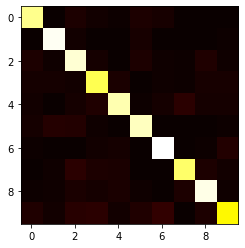

In [37]:
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.show()

In [38]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_pred)
acc_score

0.8746997598078463

In [39]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           1       0.88      0.90      0.89       236
           2       0.91      0.96      0.94       247
           3       0.81      0.87      0.84       263
           4       0.82      0.87      0.85       229
           5       0.90      0.85      0.87       262
           6       0.88      0.90      0.89       251
           7       0.90      0.93      0.91       259
           8       0.91      0.85      0.88       242
           9       0.88      0.89      0.88       265
          10       0.87      0.73      0.79       244

    accuracy                           0.87      2498
   macro avg       0.88      0.87      0.87      2498
weighted avg       0.88      0.87      0.87      2498

